In [1]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
branchCopy = branchInfo

In [4]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [5]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [6]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [7]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [8]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [9]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [10]:
appendADS(censusTracts,branchInfo, 'walking score 15 min', 'census tracts within 15 min walk','geometry','geometry','LATITUDE','LONGITUDE','geoid',15)

In [11]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,census tracts within 15 min walk
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.98717, -87.71661 41.985...",41.975579,-87.713613,"[{17031140800: 0.01499276903384414, 1703114070..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59784 41.66362, -87.59868 41.663...",41.657198,-87.598838,"[{17031540101: 0.20051111849808562, 1703154010..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72648 41.81232, -87.72822 41.811...",41.801108,-87.726484,"[{17031835200: 0.07910766166825955, 1703156040..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.90056, -87.76782 41.899...",41.889173,-87.765820,"[{17031252101: 0.07294730415303316, 1703125210..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77929 41.96473, -87.78109 41.963...",41.953123,-87.779285,"[{17031151200: 0.0667827193425643, 17031150600..."
...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64117 41.68809, -87.64217 41.688...",41.677906,-87.643168,"[{17031821402: 0.04912925273990131, 1703175060..."
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.90712, -87.66929 41.906...",41.895947,-87.668293,"[{17031833000: 0.07899963039785603, 1703128040..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.76288, -87.62695 41.753...",41.751018,-87.614951,"[{17031440202: 0.29945089054434926, 1703184240..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.73233, -87.64405 41.732...",41.720695,-87.643048,"[{17031730600: 0.16732330330805892, 1703173050..."


In [12]:
censusTracts.sort_values(by = 'walking score 15 min', ascending = False)

,geoid,qualifying name,geometry,walking score 15 min,Area
373,17031283800,"Census Tract 2838, Cook County, Illinois","POLYGON ((-87.65542 41.86702, -87.65524 41.866...",2.271364,3.762384e+05
375,17031283200,"Census Tract 2832, Cook County, Illinois","POLYGON ((-87.66120 41.87212, -87.66103 41.872...",2.248052,2.365457e+05
376,17031833300,"Census Tract 8333, Cook County, Illinois","POLYGON ((-87.65697 41.87534, -87.65697 41.875...",2.195532,4.773340e+05
374,17031283100,"Census Tract 2831, Cook County, Illinois","POLYGON ((-87.66652 41.87163, -87.66644 41.871...",2.085161,2.165148e+05
325,17031839600,"Census Tract 8396, Cook County, Illinois","POLYGON ((-87.62152 41.83106, -87.62115 41.831...",2.000000,3.270523e+05
...,...,...,...,...,...
444,17031290900,"Census Tract 2909, Cook County, Illinois","POLYGON ((-87.73977 41.86596, -87.73973 41.865...",0.000000,9.961955e+05
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,2.022143e+03
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,2.104176e+06
456,17031813000,"Census Tract 8130, Cook County, Illinois","MULTIPOLYGON (((-87.77466 41.88015, -87.77465 ...",0.000000,2.520205e+01


Text(0.5, 1.0, 'Percent of Coverage')

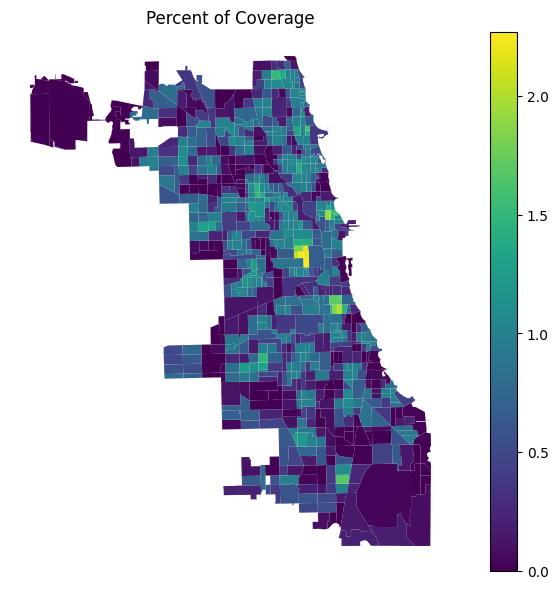

In [13]:
ax = censusTracts.plot(column = 'walking score 15 min', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [14]:
censusTracts['walking score 15 min'].mean()

0.5558867306760878

In [15]:
censusTracts['walking score 15 min norm'] = censusTracts['walking score 15 min']

In [16]:
censusTracts.loc[censusTracts['walking score 15 min norm'] > 1, 'walking score 15 min norm'] = 1.0
censusTracts.sort_values(by = 'walking score 15 min', ascending = False)

,geoid,qualifying name,geometry,walking score 15 min,Area,walking score 15 min norm
373,17031283800,"Census Tract 2838, Cook County, Illinois","POLYGON ((-87.65542 41.86702, -87.65524 41.866...",2.271364,3.762384e+05,1.0
375,17031283200,"Census Tract 2832, Cook County, Illinois","POLYGON ((-87.66120 41.87212, -87.66103 41.872...",2.248052,2.365457e+05,1.0
376,17031833300,"Census Tract 8333, Cook County, Illinois","POLYGON ((-87.65697 41.87534, -87.65697 41.875...",2.195532,4.773340e+05,1.0
374,17031283100,"Census Tract 2831, Cook County, Illinois","POLYGON ((-87.66652 41.87163, -87.66644 41.871...",2.085161,2.165148e+05,1.0
325,17031839600,"Census Tract 8396, Cook County, Illinois","POLYGON ((-87.62152 41.83106, -87.62115 41.831...",2.000000,3.270523e+05,1.0
...,...,...,...,...,...,...
444,17031290900,"Census Tract 2909, Cook County, Illinois","POLYGON ((-87.73977 41.86596, -87.73973 41.865...",0.000000,9.961955e+05,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,2.022143e+03,0.0
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,2.104176e+06,0.0
456,17031813000,"Census Tract 8130, Cook County, Illinois","MULTIPOLYGON (((-87.77466 41.88015, -87.77465 ...",0.000000,2.520205e+01,0.0


In [17]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


<Axes: >

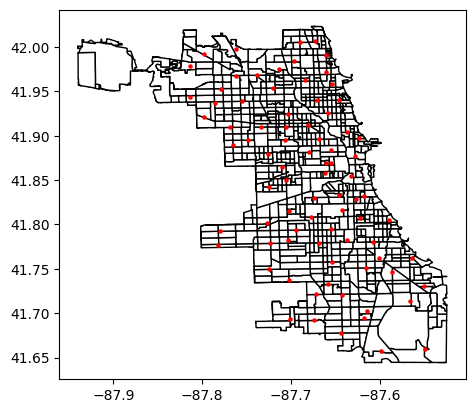

In [21]:
#fig, ax = plt.subplots(1, figsize=(10, 10))
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='black')
ax.axis('off')

branchCopy.plot(ax=base, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Walking 15 Minutes Coverage: Normalized'}>

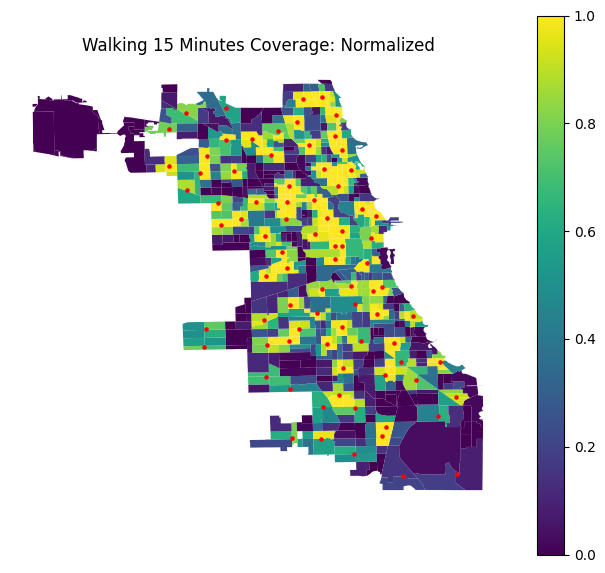

In [23]:
ax = censusTracts.plot(column = 'walking score 15 min norm', legend = True, 
                figsize=(8,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })

ax.set_axis_off()
ax.set_title("Walking 15 Minutes Coverage: Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Walking 15 Minutes Coverage'}>

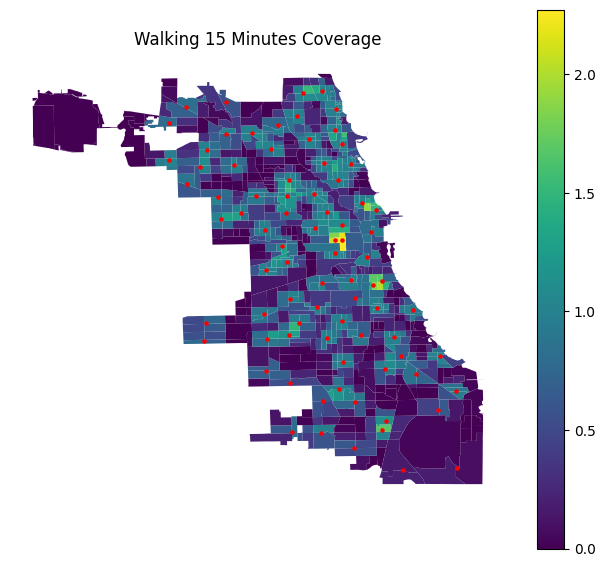

In [22]:
ax = censusTracts.plot(column = 'walking score 15 min', legend = True, 
                figsize=(8,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })

ax.set_axis_off()
ax.set_title("Walking 15 Minutes Coverage")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [27]:
censusTracts.loc[(censusTracts['geoid'] == 17031540101) | (censusTracts['geoid'] == 17031550200) | (censusTracts['geoid'] == 17031540102) | (censusTracts['geoid'] == 17031838800)]

,geoid,qualifying name,geometry,walking score 15 min,Area,walking score 15 min norm
20,17031540101,"Census Tract 5401.01, Cook County, Illinois","POLYGON ((-87.61728 41.65683, -87.61728 41.656...",0.200511,3.469339e+06,0.200511
21,17031550200,"Census Tract 5502, Cook County, Illinois","POLYGON ((-87.58914 41.66039, -87.58900 41.660...",0.180787,5.365245e+06,0.180787
42,17031540102,"Census Tract 5401.02, Cook County, Illinois","POLYGON ((-87.61807 41.66014, -87.61732 41.663...",0.154308,5.282314e+06,0.154308
44,17031838800,"Census Tract 8388, Cook County, Illinois","POLYGON ((-87.60194 41.68474, -87.60190 41.685...",0.033536,2.166624e+07,0.033536


In [37]:
appendADS(censusTracts,branchInfo, 'walking score 20 min', 'census tracts within 15 min walk','geometry','geometry','LATITUDE','LONGITUDE','geoid',20)

In [29]:
censusTracts.loc[(censusTracts['geoid'] == 17031540101) | (censusTracts['geoid'] == 17031550200) | (censusTracts['geoid'] == 17031540102) | (censusTracts['geoid'] == 17031838800)]

,geoid,qualifying name,geometry,walking score 15 min,Area,walking score 15 min norm,walking score 20 min
20,17031540101,"Census Tract 5401.01, Cook County, Illinois","POLYGON ((-87.61728 41.65683, -87.61728 41.656...",0.200511,3.469339e+06,0.200511,0.285241
21,17031550200,"Census Tract 5502, Cook County, Illinois","POLYGON ((-87.58914 41.66039, -87.58900 41.660...",0.180787,5.365245e+06,0.180787,0.255611
42,17031540102,"Census Tract 5401.02, Cook County, Illinois","POLYGON ((-87.61807 41.66014, -87.61732 41.663...",0.154308,5.282314e+06,0.154308,0.245516
44,17031838800,"Census Tract 8388, Cook County, Illinois","POLYGON ((-87.60194 41.68474, -87.60190 41.685...",0.033536,2.166624e+07,0.033536,0.061310


<Axes: title={'center': 'Walking 20 Minutes Coverage'}>

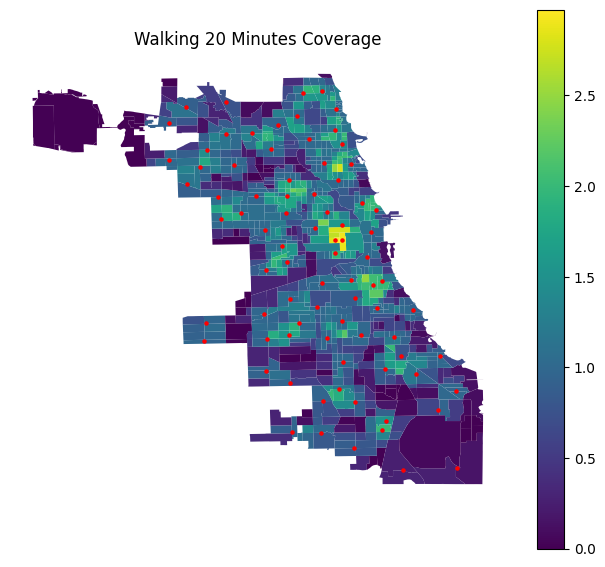

In [43]:
ax = censusTracts.plot(column = 'walking score 20 min', legend = True, 
                figsize=(8,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })

ax.set_axis_off()
ax.set_title("Walking 20 Minutes Coverage")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [39]:
censusTracts['walking score 20 min norm'] = censusTracts['walking score 20 min']


In [40]:
censusTracts.loc[censusTracts['walking score 20 min norm'] > 1, 'walking score 20 min norm'] = 1.0
censusTracts.sort_values(by = 'walking score 20 min norm', ascending = False)

,geoid,qualifying name,geometry,walking score 15 min,Area,walking score 15 min norm,walking score 20 min,walking score 20 min norm
434,17031841700,"Census Tract 8417, Cook County, Illinois","POLYGON ((-87.71110 41.85354, -87.71100 41.853...",1.014346,2.667956e+05,1.000000,1.417112,1.0
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",0.840867,8.388936e+05,0.840867,2.221772,1.0
469,17031260200,"Census Tract 2602, Cook County, Illinois","POLYGON ((-87.73032 41.88795, -87.72893 41.887...",0.985635,3.284522e+05,0.985635,1.000000,1.0
470,17031260100,"Census Tract 2601, Cook County, Illinois","POLYGON ((-87.72567 41.88796, -87.72505 41.887...",0.977766,3.254518e+05,0.977766,1.000000,1.0
471,17031836800,"Census Tract 8368, Cook County, Illinois","POLYGON ((-87.71974 41.88803, -87.71950 41.888...",0.500804,8.160162e+05,0.500804,1.224031,1.0
...,...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,2.104176e+06,0.000000,0.000000,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,2.022143e+03,0.000000,0.000000,0.0
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,1.221551e+01,0.000000,0.000000,0.0
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,7.897302e+00,0.000000,0.000000,0.0


<Axes: title={'center': 'Walking 20 Minutes Coverage: Normalized'}>

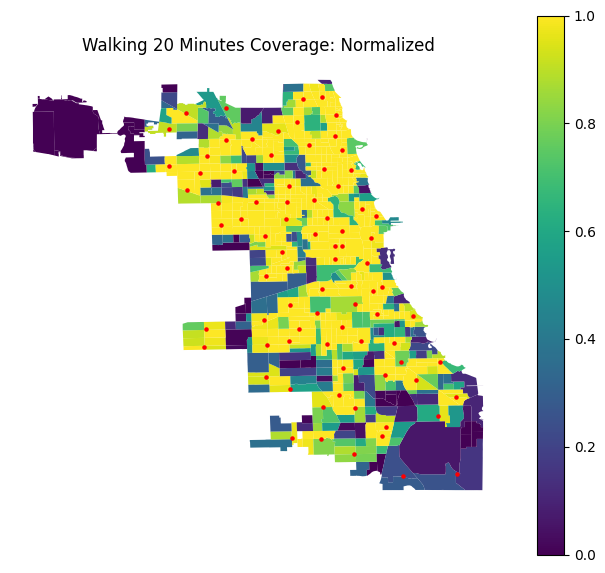

In [42]:
ax = censusTracts.plot(column = 'walking score 20 min norm', legend = True, 
                figsize=(8,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })

ax.set_axis_off()
ax.set_title("Walking 20 Minutes Coverage: Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)
